In [1]:
import os
import numpy as np 
import pandas as pd
import string
from collections import Counter
import seaborn as sns
sns.set(rc = {'figure.figsize':(12,9)})
import matplotlib.pyplot as plt
import base64

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
train = pd.read_csv('../input/train.csv')

In [3]:
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Checking the null values in the columns
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
# Dropping rows that have null values
train = train.dropna(how='any',axis=0) 

In [7]:
def remove_null_values(dataset_name):
    if train['question1'].isna().sum() > 0:
        train['question1'].fillna(" ", inplace = True)
    if train['question2'].isna().sum() > 0:
        train['question2'].fillna(" ", inplace = True)
    return train

def pre_processing(sentence):
    out = sentence
    for punct in "/-'_":
        out = out.replace(punct, ' ')
    for punct in '&':
        out = out.replace(punct, f'{punct} ')
    out = out.translate(str.maketrans('', '', string.punctuation))
    out = out.translate(str.maketrans('', '', string.digits))
    out = out.lower()
    return out

stop_words = ["the","a"]
def own_stop_words(sentence, stop_words = stop_words):
    new_sentence = []
    for word in sentence.split(' '):
        if word not in stop_words:
            new_sentence.append(word)
    return " ".join(new_sentence)

In [8]:
#train = remove_null_values(train)
train['question1'] = train['question1'].apply(pre_processing)
train['question2'] = train['question2'].apply(pre_processing)

train['question1'] = train['question1'].apply(own_stop_words)
train['question2'] = train['question2'].apply(own_stop_words)

**Data Exploration**

In [9]:
words_1 = []
for doc in train['question1']:
    for word in doc.split(' '):
        if word!='':
            words_1.append(word)

words_2 = []
for doc in train['question2']:
    for word in doc.split(' '):
        if word!='':
            words_2.append(word)

In [13]:
words_1_count = Counter(words_1)
words_2_count = Counter(words_2)

total_words = words_1_count + words_2_count
vocab_size = len(total_words)

print("Total vocab size:", vocab_size)
print(words_1_count.most_common(10))
print(words_2_count.most_common(10))

Total vocab size: 87032
[('what', 163109), ('is', 134229), ('how', 109426), ('i', 105420), ('to', 99002), ('in', 98028), ('of', 79939), ('do', 78844), ('are', 73711), ('and', 67109)]
[('what', 160722), ('is', 135584), ('i', 117416), ('how', 111204), ('to', 106734), ('in', 99027), ('do', 82188), ('of', 79927), ('are', 72168), ('and', 66815)]


In [14]:
df = pd.DataFrame(list(total_words.items()), columns=['words', 'count'])
df.sort_values(by=['count'], ascending=False, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

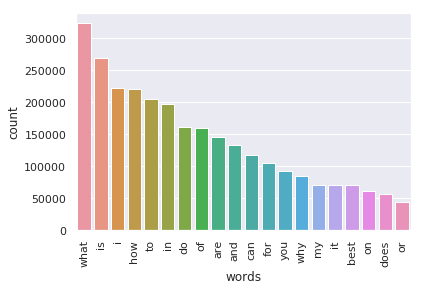

In [15]:
sns.barplot(x = df["words"][:20], y= df["count"][:20])
plt.xticks(rotation=90)

In [16]:
array = df[df['count']<=1].values.tolist()

In [17]:
doc = []
for i in array:
    doc.append(i[0])

In [18]:
from nltk.corpus import words
n_words = set(words.words())
def check(lists):
    english_count = []
    non_english_count = []
    for i in range(len(lists)):
        if lists[i] in n_words:
            english_count.append(lists[i])
        else:
            non_english_count.append(lists[i])
    return english_count, non_english_count

In [19]:
english_count, non_english_count = check(doc)

In [20]:
print(len(english_count))
print(len(non_english_count))

5073
30739


In [21]:
"""def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)"""

'def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  \n    csv = df.to_csv()\n    b64 = base64.b64encode(csv.encode())\n    payload = b64.decode()\n    html = \'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>\'\n    html = html.format(payload=payload,title=title,filename=filename)\n    return HTML(html)'

In [22]:
values = []
for row in train['question1']:
    values.append(len(row))
values = np.array(values)
#value = sorted(values)

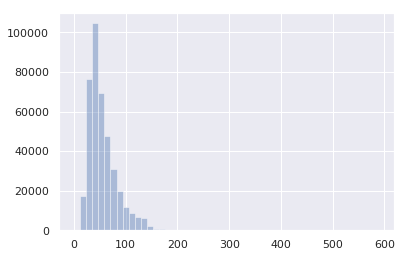

In [23]:
sns.distplot(values, kde = False)

In [25]:
## split to train and val
#train_df, val_df = train_test_split(train, test_size=0.2, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = vocab_size # how many unique words to use (i.e num rows in embedding vector)
maxlen = 150 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['question1']))
train['question1'] = tokenizer.texts_to_sequences(train['question1'])

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['question2']))
train['question2'] = tokenizer.texts_to_sequences(train['question2'])

array_1 = np.array(train['question1'])
array_2 = np.array(train['question2'])

#Pad sequences to equal length
question_1 = pad_sequences(array_1, maxlen=maxlen)
question_2 = pad_sequences(array_2, maxlen=maxlen)

In [26]:
question_1.shape

(404287, 150)

In [27]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 1147, 56, 1147, 2529, 5, 574, 6, 763, 3...","[1, 2, 1243, 58, 1243, 2499, 5, 543, 6, 724, 360]",0
1,1,3,4,"[1, 2, 477, 7, 13245, 11216, 4, 19527, 4201]","[1, 42, 176, 22, 85, 218, 10215, 14049, 15926,...",0
2,2,5,6,"[3, 11, 4, 202, 436, 7, 17, 316, 1665, 186, 13...","[4, 11, 366, 420, 20, 3074, 58, 1311, 215, 9897]",0
3,3,7,8,"[14, 78, 4, 2700, 308, 2883, 3, 11, 4, 639, 15]","[89, 3976, 38, 299, 299, 2, 2410, 58]",0
4,4,9,10,"[21, 49, 6701, 6, 219, 24880, 1922, 1996, 9581...","[23, 1999, 42, 1282, 6, 1987, 220]",0
5,5,11,12,"[2169, 4, 78, 9863, 901, 4640, 790, 10, 4640, ...","[3, 109, 5092, 9327, 890, 790, 10, 8372, 6, 93...",1
6,6,13,14,"[30, 4, 131, 24881]","[1, 2354, 35266, 1506, 10, 1075, 32, 119, 10, ...",0
7,7,15,16,"[3, 11, 4, 24, 41, 24882]","[1, 29, 3, 7, 5, 20, 314, 23335]",1
8,8,17,18,"[36, 8, 13, 76, 38575, 450, 7, 38576]","[38, 7, 13, 71, 472, 8, 10]",0
9,9,19,20,"[6589, 169, 11, 4, 428, 17, 8140, 38577, 38578]","[4, 7, 3, 437, 6422, 35267, 12, 161, 366]",0
